In [42]:
import sys
sys.path.append('..')
sys.path.append('../..')
import os
from utils import *
from student_utils_sp18 import *
from networkx.algorithms.traversal import *
from networkx.algorithms.approximation import *
from vasilis_solver import *
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
indirectory = "inputs/"
input_files = os.listdir(indirectory)

In [24]:
def get_G(number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix):
    
    name2index = {}
    index2name = {}

    count = 1
    for name in list_of_kingdom_names:
        name2index[name] = count
        index2name[count] = name
        count += 1

    G = adjacency_matrix_to_graph(adjacency_matrix)
    
    color = {}

    for node in G.nodes():
            color[node] = "white"


    conquering_cost = {}
    for node in G.nodes():
        conquering_cost[node] = adjacency_matrix[node][node]

    nx.set_node_attributes(G, conquering_cost, "conquering_cost")
    nx.set_node_attributes(G, color, "color")
    
    return G, name2index[starting_kingdom]

In [32]:
def solve_all(solver):
    indirectory = "inputs/"
    outdirectory = "outputs/"
    
    #os.makedirs(outdirectory)
    
    infiles = os.listdir(indirectory)
    
    for input_file in tqdm(infiles):
            input_data = read_file(indirectory+input_file)
            number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix = data_parser(input_data)
            
            G, start_index = get_G(number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix)
            try: 
                closed_walk, conquered_kingdoms = solver(G, start_index)
            except KeyError as e:
                print(e)
                print("Error in input file: {}".format(input_file))
            
            output_file = outdirectory + input_file[:-3] +".out"
            write_data_to_file(output_file, closed_walk, ' ')
            write_to_file(output_file, '\n', append=True)
            write_data_to_file(output_file, conquered_kingdoms, ' ', append=True)

In [33]:
solve_all(vasilis_solver)


  2%|▏         | 17/716 [00:05<03:53,  3.00it/s]

'Key 100 not found'
Error in input file: 618.in



  7%|▋         | 52/716 [00:25<05:21,  2.07it/s]

'Key 49 not found'
Error in input file: 383.in


 13%|█▎        | 91/716 [00:41<04:45,  2.19it/s]

'Key 199 not found'
Error in input file: 382.in


 17%|█▋        | 122/716 [00:55<04:28,  2.21it/s]

'Key 50 not found'
Error in input file: 386.in


 21%|██        | 148/716 [01:12<04:36,  2.05it/s]

'Key 49 not found'
Error in input file: 116.in


 22%|██▏       | 154/716 [01:13<04:30,  2.08it/s]

'Key 31 not found'
Error in input file: 544.in


 26%|██▌       | 187/716 [01:38<04:39,  1.90it/s]

'Key 50 not found'
Error in input file: 11.in


 29%|██▊       | 205/716 [01:53<04:43,  1.80it/s]

'Key 50 not found'
Error in input file: 707.in


 30%|██▉       | 212/716 [01:56<04:37,  1.81it/s]

'Key 200 not found'
Error in input file: 511.in


 32%|███▏      | 228/716 [02:02<04:22,  1.86it/s]

'Key 100 not found'
Error in input file: 723.in


 35%|███▌      | 254/716 [02:21<04:16,  1.80it/s]

'Key 200 not found'
Error in input file: 646.in


 36%|███▌      | 257/716 [02:28<04:24,  1.73it/s]

'Key 200 not found'
Error in input file: 706.in


 36%|███▋      | 260/716 [02:29<04:21,  1.74it/s]

'Key 100 not found'
Error in input file: 510.in


 41%|████▏     | 297/716 [02:54<04:05,  1.70it/s]

KeyboardInterrupt: 

In [49]:
input_data = read_file("inputs/11.in")
number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix = data_parser(input_data)

In [58]:
G, start_index = get_G(number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix)

In [59]:
import networkx as nx

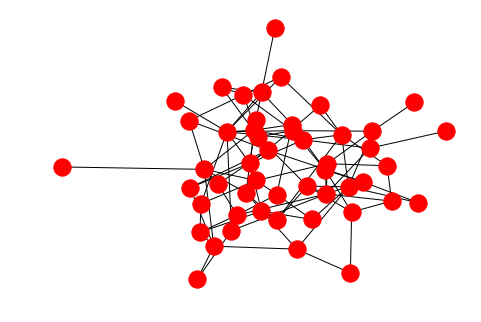

In [60]:
nx.draw(G)

In [61]:
closed_walk, conquered_kingdoms = vasilis_solver(G, start_index)

Before the disaster
50


KeyError: 'Key 50 not found'

In [56]:
import sys
sys.path.append('..')
sys.path.append('../..')
import os
from utils import *
from student_utils_sp18 import *
from networkx.algorithms.traversal import *
from networkx.algorithms.approximation import *


# Util functions

#utils
# calculate the heuristic for all nodes on the graph

def conquer_gain(G, node):
    """Given a Graph and a node it calculates the value of the heuristic for the node"""
    """conquering_cost_neighbors/conquering_cost_current_node larger is better"""
    
    if G.node[node]['color'] =="black": # do not calculate the heuristic for black nodes
        return 0
    else:
        neighbors = nx.neighbors(G, node)
        
        neighbors_conquering_cost = 0
        for n in neighbors:
            neighbors_conquering_cost += G.node[n]['conquering_cost']
        
        return neighbors_conquering_cost/G.node[node]['conquering_cost']
    
# update the colors in the graph

def update_graph(G, node):
    G.node[node]['color'] = "black"
    neighbors = nx.neighbors(G, node)
    
    for n in neighbors:
        if G.node[n]['color'] == "white":
            G.node[n]['color'] = "grey"
    return

# find the the nodes that we need to visit based on heuristic

def choose_node(G):
    # calculate heuristic for everyone
    heuristic_value = []

    for node in G.nodes():
        heuristic_value.append(conquer_gain(G, node))

    chosen_node = np.argmax(heuristic_value)
    return chosen_node

def all_conquered(G):
    lst = [l[1] for l in nx.get_node_attributes(G, "color").items()]
    
    return not "white" in lst

# recover the order of traversal of the tree

def find_traversal(tree, start_index):
    """Recovers the traversal of the Steiner tree using DFS (the full walk tho)"""
    print("Before the disaster")
    print(start_index)
    vertex_order = list(dfs_preorder_nodes(tree, start_index))+[start_index]
    current_node = start_index
    full_walk = [start_index]

    for next_node in vertex_order[1:]:
        #print(current_node, next_node)
        path = list(nx.all_simple_paths(tree, current_node, next_node))[0]
        full_walk.extend(path[1:])
        current_node = next_node
    return full_walk


def vasilis_solver(G, start_index):
    # find nodes to visit
    
    nodes_to_visit = []

    while not all_conquered(G):
        next_node = choose_node(G)
        nodes_to_visit.append(next_node)
        update_graph(G, next_node)
    
    # Handle the edge case from below
    if nodes_to_visit[0]==start_index:
        return [start_index], [start_index]
    
    # get Steiner tree
    # CURRENTLY HAS THE BUG THAT THE STEINER TREE DOES NOT WORK WHEN YOU ONLY HAVE 1 TARGET VERTEX
    ST = steinertree.steiner_tree(G, set(nodes_to_visit+[start_index]))

    # Find the traversal based on the Steiner tree
    traversal = find_traversal(ST, start_index)
    conquered = dict(zip(nodes_to_visit, [False]*len(nodes_to_visit)))
    to_conquer = []

    for n in traversal:
        if n in nodes_to_visit and conquered[n] == False:
            to_conquer.append(n)
            conquered[n]=True
            
    return traversal, to_conquer